<a href="https://colab.research.google.com/github/Brymer-Meneses/PyTorch-Basics/blob/master/Cat_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [38]:
import torch
import torchvision
from torchvision import transforms
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd
import os
from zipfile import ZipFile
from skimage import io

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/External Datasets/Kaggle"

In [5]:
!kaggle competitions download -c dogs-vs-cats

 96% 522M/543M [00:04<00:00, 114MB/s] 
100% 543M/543M [00:04<00:00, 127MB/s]
100% 270M/271M [00:02<00:00, 105MB/s]
100% 271M/271M [00:02<00:00, 105MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 84.0MB/s]


In [6]:
zip_path = '/content/train.zip'

zip = ZipFile(zip_path, 'r')
zip.extractall()

In [7]:
data = os.listdir('/content/train')
ds = pd.DataFrame()
ds['file'] = data

In [8]:
def classify(img):
  if img.split('.')[0] == 'dog':
    return 1
  elif img.split('.')[0] == 'cat':
    return 0

In [9]:
ds['target'] = list(map(classify, ds['file']))

In [11]:
ds.to_csv(r'/content/train.csv', index = False, header = False)

In [12]:
# DataLoader

class CatsAndDogsDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform = None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations) 
  
  def __getitem__(self, index):
   
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
    image = io.imread(img_path)
    y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

    if self.transform:
      image = self.transform(image)
    
    return (image, y_label)


In [13]:
T = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(255),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

In [14]:


dataset = CatsAndDogsDataset(csv_file = '/content/train.csv',
                             root_dir = '/content/train', 
                             transform = T
                            )

In [15]:
def imshow(img, title):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title == 1:
      plt.title("dog")
    else:
      plt.title('cat')
    plt.show()


In [16]:
dataiter = iter(dataset)

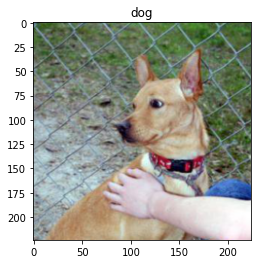

In [17]:
img, label = next(dataiter)
imshow(img, label)

In [19]:
train_set , test_set = torch.utils.data.random_split(dataset, [20000, 4999])

In [20]:
train_loader = DataLoader(dataset = train_set, batch_size = 64, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = 64, shuffle = False)

# Create Neural Network

In [21]:
# nn_out = floor((n_in + 2p - k)/s) + 1

In [22]:
# image size = 224 x 224

class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3,       # 224 x 224 -> 222 x 222
                           out_channels = 64,
                           kernel_size = 3)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)   # 222 x 222 -> 111 x 111
    self.batchnorm1 = nn.BatchNorm2d(64)
    self.dropout1 = nn.Dropout(p = 0.5)

    self.conv2 = nn.Conv2d(in_channels = 64,         # 111 x 111 -> 106 x 106
                           out_channels = 128,
                           kernel_size = 5)
    self.maxpool2 = nn.MaxPool2d(kernel_size = 2)  # 106 x 106 -> 53 x 53
    self.batchnorm2 = nn.BatchNorm2d(128)
    self.dropout2 = nn.Dropout(p = 0.3)

    self.conv3 = nn.Conv2d(in_channels = 128,     # 53 x 53 -> 46 x 46
                           out_channels = 256,
                           kernel_size = 7)
    self.maxpool3 = nn.MaxPool2d(kernel_size=2)  # 46 x 46 -> 23 x 23
    self.batchnorm3 = nn.BatchNorm2d(256)
    self.dropout3 = nn.Dropout(p = 0.2)

    self.fc1 = nn.Linear(256*23*23, 1000)
    self.dropout4 = nn.Dropout(p = 0.1)

    self.fc2 = nn.Linear(1000, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.maxpool1(x)
    x = self.batchnorm1(x)
    x = self.dropout1(x)
   

    x = self.conv2(x)
    x = F.relu(x)
    x = self.maxpool2(x)
    x = self.batchnorm2(x)
    x = self.dropout2(x)
   

    x = self.conv3(x)
    x = F.relu(x)
    x = self.maxpool3(x)
    x = self.batchnorm3(x)
    x = self.dropout3(x)
  
    x = x.reshape(x.size(0), -1)
    x = self.fc1(x)
    x = self.dropout4(x)
    x = F.relu(x)
    x = self.fc2(x)
 
    return F.log_softmax(x,1)


In [23]:
model = ConvNet()

In [24]:
model

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=135424, out_features=1000, bias=True)
  (dropout4): Dropout(p=0.1, inplace=False)
  (fc2)

In [25]:
# HyperParameters
n_epochs = 10
lr = 0.001


In [26]:
model.to('cuda')

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=135424, out_features=1000, bias=True)
  (dropout4): Dropout(p=0.1, inplace=False)
  (fc2)

In [27]:

cec_loss = nn.CrossEntropyLoss()
params = model.parameters()
optimizer = optim.Adam(params = params, lr = 0.001)

n_epochs = 3
n_iterations = 0

In [40]:
def train_net(model, n_epochs, train_loader):
  if torch.cuda.is_available():
    device = "cuda"
  else:
    device = "cpu"
  print(f'now running on {device}')
  model.to(device)
  #model.train()
 
  loss_over_time = []

  for epoch in range(n_epochs):
    running_loss = 0.0
    loop = tqdm(enumerate(train_loader), total = len(train_loader), leave = True)
    for batch_i, (images, labels) in loop:
      IMAGES = Variable(images).to(device)
      LABELS = Variable(labels).to(device)

      
      model.zero_grad()
      output = model(IMAGES)

      loss = cec_loss(output, LABELS)

      loss.backward()

      optimizer.step()

      running_loss += loss.item()
      total = 0
      correct = 0
      if batch_i % 10 == 9:
        avg_loss = running_loss/10
        loss_over_time.append(avg_loss)

        _, predicted = torch.max(output.data, 1)
        total += LABELS.size(0)
        correct += (predicted == LABELS).sum().item()

        # update progress bar
        accuracy = 100*(correct/total)
        loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
        loop.set_postfix(loss = loss.item(), acc=accuracy)

        #print(f'Epoch {epoch + 1}, Batch Index: {batch_i +1}, Accuracy: {100*(correct/total)}, Avg. Loss: {avg_loss}')
        running_loss = 0.0

  print("Finished Training")
  return loss_over_time

In [41]:
n_epochs = 3


training_loss = train_net(model, n_epochs, train_loader)

now running on cuda



Finished Training


# Testing

In [42]:
test_zip_path = '/content/test1.zip'

test_zip = ZipFile(test_zip_path, 'r')
test_zip.extractall()

In [43]:
test_path = '/content/test1'

In [44]:
torch.save(model.state_dict(), '/content/CNN.pt')

In [45]:
test_images = iter(os.listdir(test_path))


In [49]:
print(T)

Compose(
    ToPILImage()
    Resize(size=255, interpolation=PIL.Image.BILINEAR)
    RandomCrop(size=(224, 224), padding=None)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)


In [122]:
def randshow(root, image_path):
    model.to('cpu')
    
    path = os.path.join(root, image_path)
    img = io.imread(path)
    img = T(img)
    img = img.unsqueeze(0)

    results = model(img)
    img = img / 2 + 0.5
    npimg = img.numpy()
    disp_img = np.transpose(npimg, (2,3,1,0))

    disp_img = disp_img.reshape(224,224,3)
   
    plt.imshow(disp_img)
    
    result = results.argmax().item()

    title = 'Behold a majestic cat' if result == 0 else 'behold a majestic dog'
    
    plt.title(title)
    plt.show()
    return

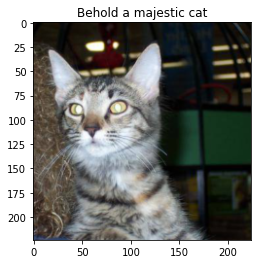

In [155]:
randshow('/content/test1', next(test_images))